# Interpretability

We will create for each output of the policy a global surrogate model.

In [1]:
import os
import torch
import gymnasium
from gymnasium.spaces import Box, Tuple, Discrete
import numpy as np
from gym_platform.envs.platform_env import PlatformEnv

class ToGymnasium(gymnasium.Env):
    def __init__(self, env, render_mode='human'):
        self.env = env
        self.render_mode = render_mode
        # self.observation_space = convert_space(self.env.observation_space)

        # flatten the observation space
        self.observation_space = Box(
            low=np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
            high=np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
            dtype=np.float64,
        )

        self.action_scale = [30., 720., 430.]
        self.action_space = Tuple([
            Discrete(3),
            Tuple([
                Box(low=-1., high=1., shape=(1,), dtype=np.float32),
                Box(low=-1., high=1., shape=(1,), dtype=np.float32),
                Box(low=-1., high=1., shape=(1,), dtype=np.float32),
            ])
        ])

    def reset(self, *, seed: int | None = None, options: dict | None = None):
        state = self.env.reset()
        state = np.append(state[0], state[1]/200.)
        return state, {}

    def step(self, action):
        # rescale action
        action = (
            action[0],
            [(x + 1) * scale / 2 for x, scale in zip(action[1], self.action_scale)],
        )

        state, reward, done, info = self.env.step(action)
        state = np.append(state[0], state[1]/200.)
        done = bool(done)
        return state, reward, done, done, info
    
    def render(self):
        if self.render_mode == 'rgb_array':
            frames = []
            self.env._initialse_window()
            for render_state in self.env.render_states:
                self.env._draw_render_state(render_state)
                frames.append(self.env._get_image())
            self.env.render_states = []
            return frames
        else:
            return self.env.render(mode=self.render_mode)
    
    def close(self):
        self.env.render(mode=self.render_mode, close=True)
        return self.env.close()

env = ToGymnasium(PlatformEnv())


In [2]:
feature_names = ['pos_x', 'vel_x', 'enemy_pox_x', 'enemy_vel_x', 'enemy_dx', 'plat_pos', 'plat_wd1', 'plat_wd2', 'gap', 'diff']
actions_names = ['run', 'hop', 'leap']

In [3]:
from ray.rllib.policy.policy import Policy
policy = Policy.from_checkpoint('last_policy')

/home/seiras/.pyenv/versions/3.10.12/envs/gym-platform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-16 19:00:53,036	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-16 19:00:54,181	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-16 19:00:55,646	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependenc

## Collect data for 200 episodes

In [4]:
x, y = [], []
for _ in range(200):
    state, _ = env.reset()
    while True:
        action = policy.compute_single_action(state)[0]
        x.append(state)
        y.append(action)
        state, reward, done1, done2, _ = env.step(action)
        done = done1 or done2
        if done:
            break
env.close()


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=0)
y_actions_train, y_dx_train = zip(*y_train)
y_actions_test, y_dx_test = zip(*y_test)
y_dx_train = list(zip(*y_dx_train))
y_dx_test = list(zip(*y_dx_test))

# to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_actions_train = np.array(y_actions_train)
y_actions_test = np.array(y_actions_test)
y_dx_train = np.array(y_dx_train)
y_dx_test = np.array(y_dx_test)

## Action output

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model_actions = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth=3).fit(x_train, y_actions_train)
y_actions_pred = model_actions.predict(x_test)

print(classification_report(y_actions_test, y_actions_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       274
           1       0.98      0.68      0.80       297
           2       0.33      0.95      0.49        22

    accuracy                           0.83       593
   macro avg       0.72      0.87      0.73       593
weighted avg       0.89      0.83      0.84       593



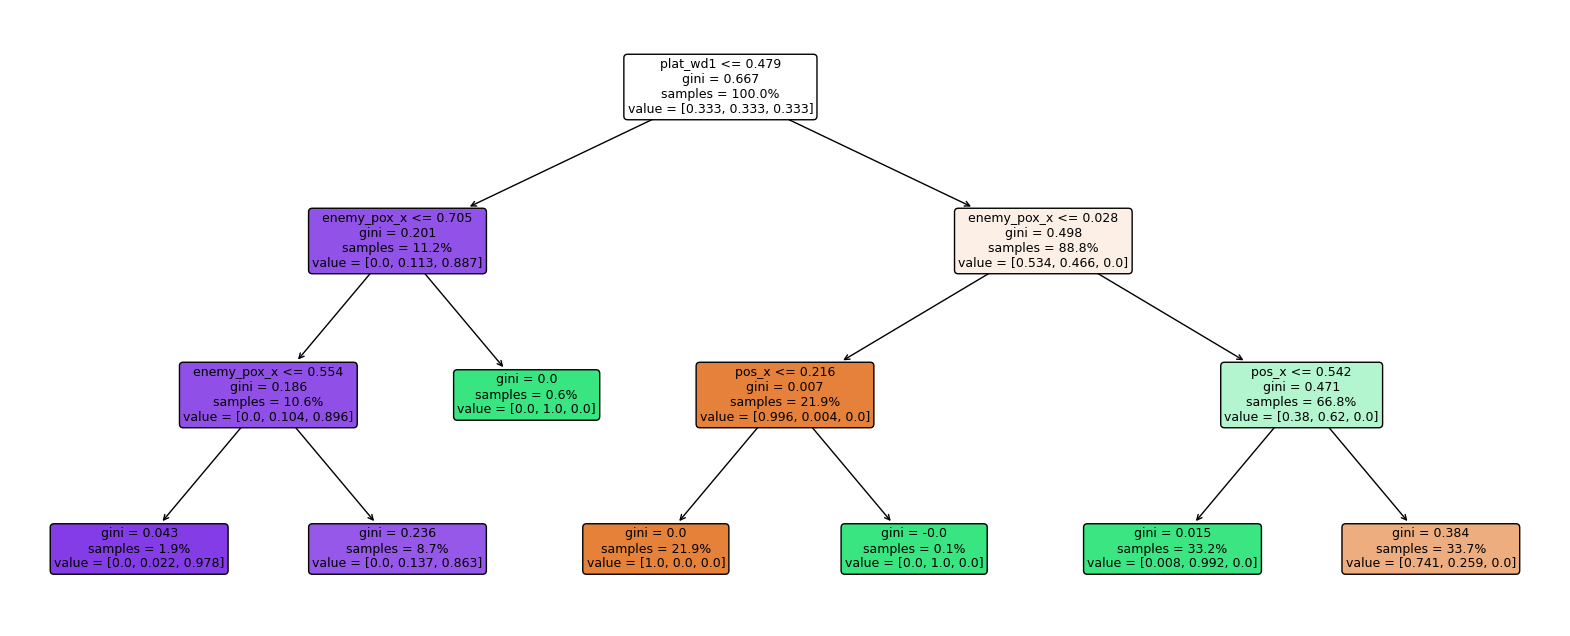

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,8))
plot_tree(model_actions, feature_names=feature_names, filled=True, fontsize=9, rounded=True, proportion=True)
plt.show()


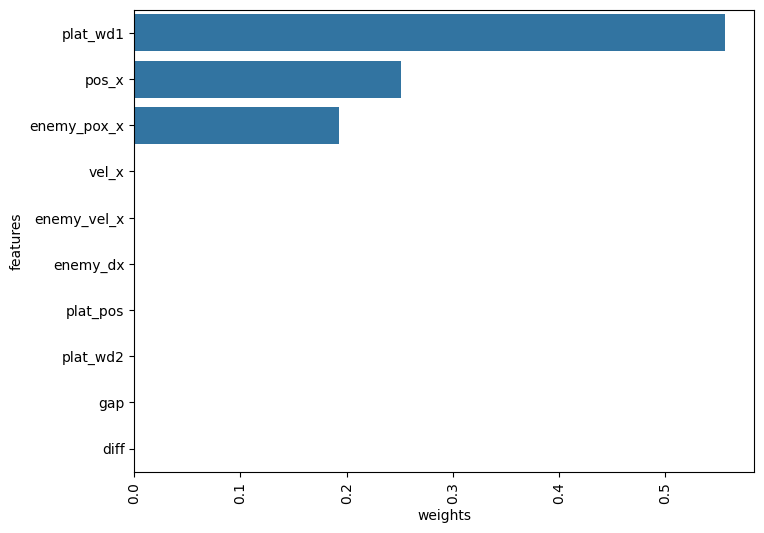

In [8]:
import pandas as pd
import seaborn as sns

weights = model_actions.feature_importances_
model_weights = pd.DataFrame({'features': feature_names, 'weights': list(weights)})
model_weights = model_weights.sort_values(by='weights', ascending=False)

plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(x="weights", y="features", data=model_weights)
plt.xticks(rotation=90)
plt.show()


## dx outputs

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
    # Regression metrics
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('r2: ', round(r2,4))
    print()

models_dx = []
for i in range(len(y_dx_test)):
    model_dx = Ridge(random_state=0).fit(x_train, y_dx_train[i])
    y_dx_pred = model_dx.predict(x_test)
    print(f'Output: {actions_names[i]}')
    regression_results(y_dx_test[i], y_dx_pred)

    models_dx.append(model_dx)

Output: run
MAE:  0.641
MSE:  0.7351
RMSE:  0.8574
r2:  0.0948

Output: hop
MAE:  0.4852
MSE:  0.4836
RMSE:  0.6954
r2:  0.2438

Output: leap
MAE:  0.8967
MSE:  1.2355
RMSE:  1.1115
r2:  0.0733



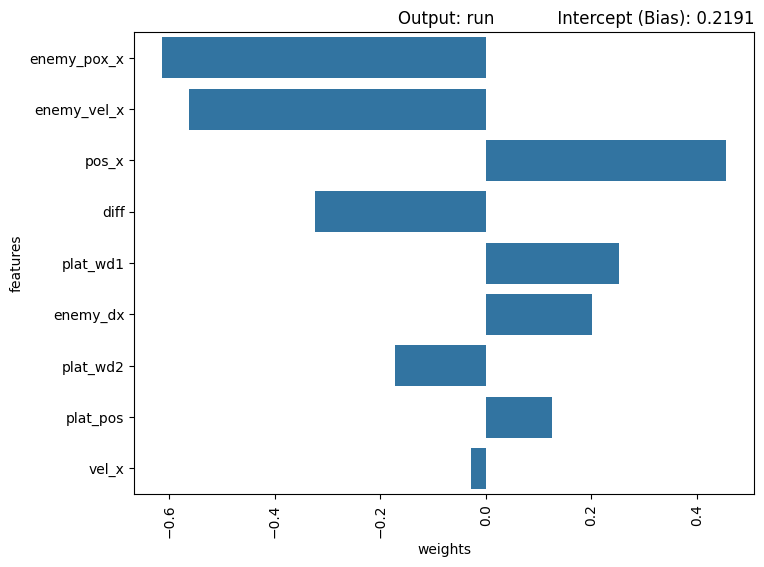

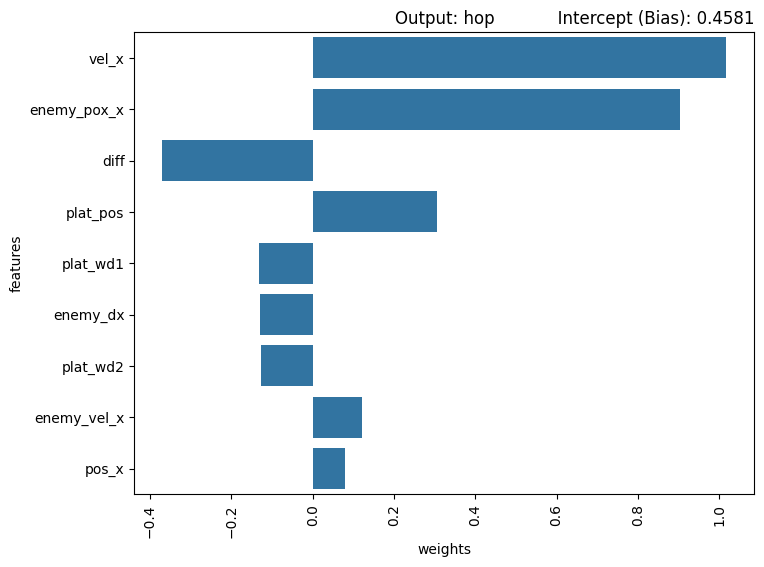

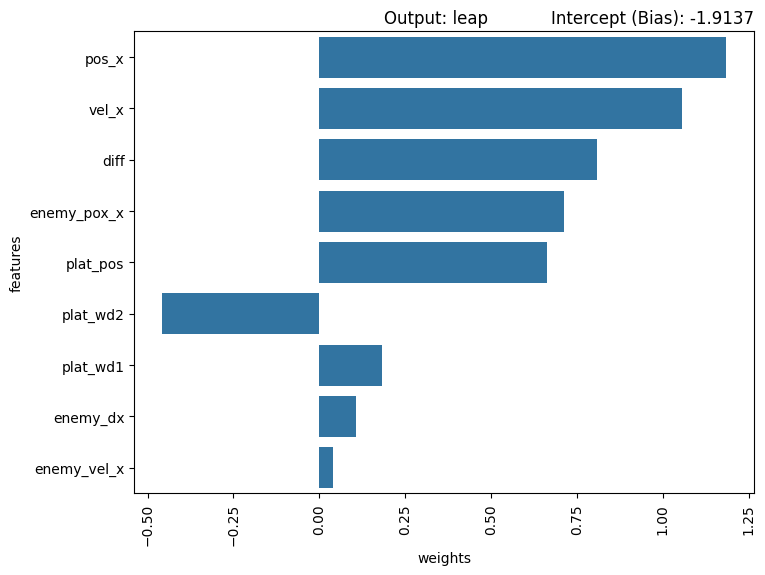

In [10]:
for i, model in enumerate(models_dx):
    weights = model.coef_
    model_weights = pd.DataFrame({ 'features': list(feature_names),'weights': list(weights[0])})
    model_weights = model_weights.sort_values(by='weights', ascending=False)
    model_weights = model_weights.reindex(model_weights['weights'].abs().sort_values(ascending=False).index)
    model_weights = model_weights[(model_weights["weights"] != 0)]    

    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
    sns.barplot(x="weights", y="features", data=model_weights)
    plt.title(f"Output: {actions_names[i]} {10*' '} Intercept (Bias): {model.intercept_[0]:.4f}", loc='right')
    plt.xticks(rotation=90)
    plt.show()

### dx outputs but using only the data when the action is selected

In [11]:
models2_dx = []
for i in range(len(y_dx_test)):
    idx_train = y_actions_train == i
    idx_test = y_actions_test == i
    model_dx = Ridge(random_state=0).fit(x_train[idx_train], y_dx_train[i][idx_train])
    y_dx_pred = model_dx.predict(x_test[idx_test])
    print(f'Output: {actions_names[i]}')
    regression_results(y_dx_test[i][idx_test], y_dx_pred)

    y_dx_pred = model_dx.predict(x_test)
    print(f'Output: {actions_names[i]} | ALL')
    regression_results(y_dx_test[i], y_dx_pred)

    models2_dx.append(model_dx)

Output: run
MAE:  0.424
MSE:  0.3557
RMSE:  0.5964
r2:  0.1933

Output: run | ALL
MAE:  0.6573
MSE:  0.7769
RMSE:  0.8814
r2:  0.0433

Output: hop
MAE:  0.3593
MSE:  0.2954
RMSE:  0.5435
r2:  0.3734

Output: hop | ALL
MAE:  0.4926
MSE:  0.5027
RMSE:  0.709
r2:  0.214

Output: leap
MAE:  0.8652
MSE:  1.0091
RMSE:  1.0046
r2:  -0.0168

Output: leap | ALL
MAE:  0.9313
MSE:  1.319
RMSE:  1.1485
r2:  0.0107



## Record the model performance

In [16]:
from gymnasium.wrappers.monitoring import video_recorder
import os

def record_video(env, filename, compute_action):
    path = 'videos'
    os.makedirs(path, exist_ok = True) 

    # record video of the result
    video = video_recorder.VideoRecorder(env, path=f'{path}/{filename}')
    state, _ = env.reset()
    frames = env.render()
    video.recorded_frames.extend(frames)
    while True:
        action = compute_action(state)
        state, _, terminated, truncated, _ = env.step(action)
        frames = env.render()
        video.recorded_frames.extend(frames)
        if terminated or truncated: break
    video.close()
    env.close()

record_video(
    ToGymnasium(PlatformEnv(), render_mode='rgb_array'),
    'ppo_policy.mp4',
    lambda state: policy.compute_single_action(state)[0],
)
record_video(
    ToGymnasium(PlatformEnv(),
    render_mode='rgb_array'),
    'surrogate.mp4',
    lambda state: (model_actions.predict([state])[0], [model.predict([state])[0] for model in models_dx])
)
record_video(
    ToGymnasium(PlatformEnv(),
    render_mode='rgb_array'),
    'surrogate2.mp4',
    lambda state: (model_actions.predict([state])[0], [model.predict([state])[0] for model in models2_dx])
)

Moviepy - Building video videos/ppo_policy.mp4.
Moviepy - Writing video videos/ppo_policy.mp4



Moviepy - Done !
Moviepy - video ready videos/ppo_policy.mp4
Moviepy - Building video videos/surrogate.mp4.
Moviepy - Writing video videos/surrogate.mp4



Moviepy - Done !
Moviepy - video ready videos/surrogate.mp4
Moviepy - Building video videos/surrogate2.mp4.
Moviepy - Writing video videos/surrogate2.mp4



Moviepy - Done !
Moviepy - video ready videos/surrogate2.mp4


## PPO policy

In [17]:
from IPython.display import Video

Video("videos/ppo_policy.mp4")

## Global surrogate models

In [18]:
Video("videos/surrogate.mp4")

In [19]:
Video("videos/surrogate2.mp4")